# Plant Seedlings Classification - Tensorflow Project

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import glob
from IPython.display import Image
import cv2

In [2]:
print("Tensorflow Version",tf.__version__)

Tensorflow Version 1.3.0


In [3]:
IMG_SIZE = (51, 51)
COLOR_CHANNELS = 3

## Augmentation Functions

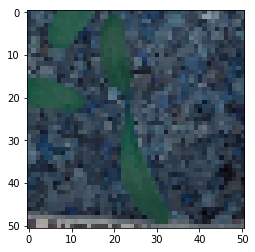

In [4]:
sample = cv2.resize(cv2.imread('../data/SeedlingData/train/Sugar beet/1347ac5ac.png'), IMG_SIZE)
plt.imshow(sample)

In [5]:
def histogram_equalize(img):
    if(COLOR_CHANNELS == 1):
        return cv2.equalizeHist(img)
        
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

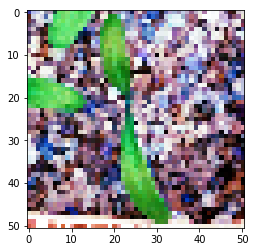

In [6]:
sample = histogram_equalize(sample)
plt.imshow(sample)

In [7]:
def random_rotate(img):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), random.randrange(360), 1)
    img_rotation = cv2.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return img_rotation

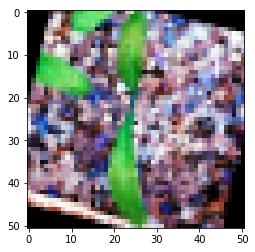

In [8]:
sample = random_rotate(sample)
plt.imshow(sample)

In [9]:
def random_zoom(img):
    x1, y1 = random.randrange(0, 5), random.randrange(0, 5)
    x2, y2 = random.randrange(45, 51), random.randrange(45, 51)
    img = img[y1:y2, x1:x2]
    img = cv2.resize(img, IMG_SIZE)
    return img

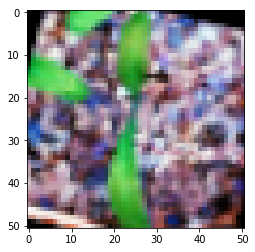

In [10]:
sample = random_zoom(sample)
plt.imshow(sample)

## Data

### - One Hot labels

In [11]:
dirs = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
       'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
values = np.array(dirs)
# print(values,'\n')

#transformando em one hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encodeded = np.array(onehot_encoder.fit_transform(integer_encoded)).astype(int)
# print(onehot_encodeded)

### - Training Data

In [12]:
training_path = '../data/SeedlingData/train/'
training_data = []
__ = -1;
for img_class in dirs:
    __ += 1
    for filename in glob.glob(training_path+img_class+'/*.png'):
        im = cv2.imread(filename)
        im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE)))#.ravel()
        training_data.append([im, onehot_encodeded[__]])
random.shuffle(training_data)

### - Test Data

In [13]:
test_path = '../data/SeedlingData/test/'
test_data = []
for filename in glob.glob(test_path+'/*.png'):
    im = cv2.imread(filename)
    im = histogram_equalize(np.array(cv2.resize(im, IMG_SIZE))).ravel()
    test_data.append([im, filename.split('/')[-1]])

### Building Model

In [14]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(init_random_dist)

In [15]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [16]:
def conv2d(x, W):
    #x -> [batch, H, W, Channels]
    #W -> [filter H, filter W, Channels IN, Channels Out]
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [17]:
def max_pool_2by2(x):
    #x -> [batch, H, W, Channels]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides = [1,2,2,1], padding='SAME')

In [18]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

In [19]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [20]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, IMG_SIZE[0]*IMG_SIZE[1]*COLOR_CHANNELS])
y_ = tf.placeholder(tf.float32, shape=[None, 12])

In [21]:
#layers
x_image = tf.reshape(x, [-1, IMG_SIZE[0], IMG_SIZE[1], COLOR_CHANNELS])

In [22]:
convo_1 = convolutional_layer(x_image, shape=[5,5,COLOR_CHANNELS,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [23]:
convo_2 = convolutional_layer(convo_1_pooling, shape=[5,5,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [24]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 13*13*64])

In [25]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [26]:
#dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [27]:
y_pred = normal_full_layer(full_one_dropout, 12)

In [28]:
#Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))

In [29]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

## Batch Loader

In [30]:
def load_batch(size):
    batch_x, batch_y = [],[]
    for _ in range(size):
            rand_val = random.randrange(0,len(test_data))
#             batch_x.append(training_data[rand_val][0].ravel())
            batch_x.append(random_zoom(random_rotate(training_data[rand_val][0])).ravel())
            batch_y.append(training_data[rand_val][1])
    return batch_x, batch_y    

## Runing Session

In [31]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [32]:
steps = 80000

In [33]:
plot_data = []
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = load_batch(batch_size)
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        feed = {x:batch_x, y_:batch_y, hold_prob:0.5}
        sess.run(train, feed_dict = feed)
        
        if i%100 == 0:
            temp_plot = sess.run(cross_entropy, feed_dict = feed)
            plot_data.append(temp_plot)
            print('ON STEP: {} - COST: {} '.format(i, temp_plot))
    #saving trained model
    save_path = saver.save(sess, "./seedlings-model.ckpt")
    print("Model saved in path: %s" % save_path)

ON STEP: 0 - COST: 10327.876953125 
ON STEP: 100 - COST: 7.347319602966309 
ON STEP: 200 - COST: 3.8898868560791016 
ON STEP: 300 - COST: 2.892828941345215 
ON STEP: 400 - COST: 2.774636745452881 
ON STEP: 500 - COST: 2.4712836742401123 
ON STEP: 600 - COST: 2.5137734413146973 
ON STEP: 700 - COST: 2.562088966369629 
ON STEP: 800 - COST: 2.4292404651641846 
ON STEP: 900 - COST: 2.4546217918395996 
ON STEP: 1000 - COST: 2.3289437294006348 
ON STEP: 1100 - COST: 2.4922678470611572 
ON STEP: 1200 - COST: 2.4058027267456055 
ON STEP: 1300 - COST: 2.537405252456665 
ON STEP: 1400 - COST: 2.5394554138183594 
ON STEP: 1500 - COST: 2.4794182777404785 
ON STEP: 1600 - COST: 2.4474587440490723 
ON STEP: 1700 - COST: 2.3814895153045654 
ON STEP: 1800 - COST: 2.3681752681732178 
ON STEP: 1900 - COST: 2.4424996376037598 
ON STEP: 2000 - COST: 2.4913370609283447 
ON STEP: 2100 - COST: 2.560365915298462 
ON STEP: 2200 - COST: 2.2989373207092285 
ON STEP: 2300 - COST: 2.3160762786865234 
ON STEP: 2400

ON STEP: 19600 - COST: 2.246551990509033 
ON STEP: 19700 - COST: 2.2877655029296875 
ON STEP: 19800 - COST: 2.123878240585327 
ON STEP: 19900 - COST: 2.046868324279785 
ON STEP: 20000 - COST: 2.156073570251465 
ON STEP: 20100 - COST: 1.8732516765594482 
ON STEP: 20200 - COST: 2.283571243286133 
ON STEP: 20300 - COST: 2.0282180309295654 
ON STEP: 20400 - COST: 2.235229015350342 
ON STEP: 20500 - COST: 2.1735358238220215 
ON STEP: 20600 - COST: 2.136936664581299 
ON STEP: 20700 - COST: 2.184771776199341 
ON STEP: 20800 - COST: 2.1316628456115723 
ON STEP: 20900 - COST: 2.0823171138763428 
ON STEP: 21000 - COST: 2.1236038208007812 
ON STEP: 21100 - COST: 2.1359052658081055 
ON STEP: 21200 - COST: 2.1902050971984863 
ON STEP: 21300 - COST: 2.1241605281829834 
ON STEP: 21400 - COST: 2.309579849243164 
ON STEP: 21500 - COST: 1.9759800434112549 
ON STEP: 21600 - COST: 1.9908390045166016 
ON STEP: 21700 - COST: 2.0395312309265137 
ON STEP: 21800 - COST: 2.0610151290893555 
ON STEP: 21900 - COS

ON STEP: 38900 - COST: 1.9255318641662598 
ON STEP: 39000 - COST: 1.8312056064605713 
ON STEP: 39100 - COST: 1.8547487258911133 
ON STEP: 39200 - COST: 1.7126623392105103 
ON STEP: 39300 - COST: 1.7452051639556885 
ON STEP: 39400 - COST: 2.0271151065826416 
ON STEP: 39500 - COST: 2.195303201675415 
ON STEP: 39600 - COST: 1.8070099353790283 
ON STEP: 39700 - COST: 2.1406731605529785 
ON STEP: 39800 - COST: 1.9995026588439941 
ON STEP: 39900 - COST: 1.9979279041290283 
ON STEP: 40000 - COST: 1.8548957109451294 
ON STEP: 40100 - COST: 1.7156716585159302 
ON STEP: 40200 - COST: 1.857492446899414 
ON STEP: 40300 - COST: 1.795858383178711 
ON STEP: 40400 - COST: 1.9492621421813965 
ON STEP: 40500 - COST: 1.9615051746368408 
ON STEP: 40600 - COST: 2.015192985534668 
ON STEP: 40700 - COST: 1.907397985458374 
ON STEP: 40800 - COST: 2.2092771530151367 
ON STEP: 40900 - COST: 1.87868070602417 
ON STEP: 41000 - COST: 1.7280060052871704 
ON STEP: 41100 - COST: 1.7945153713226318 
ON STEP: 41200 - C

ON STEP: 58100 - COST: 0.5877720713615417 
ON STEP: 58200 - COST: 0.6248649954795837 
ON STEP: 58300 - COST: 0.5284221172332764 
ON STEP: 58400 - COST: 0.554797887802124 
ON STEP: 58500 - COST: 0.6099224090576172 
ON STEP: 58600 - COST: 0.5232141613960266 
ON STEP: 58700 - COST: 0.39903855323791504 
ON STEP: 58800 - COST: 0.7447588443756104 
ON STEP: 58900 - COST: 0.38345903158187866 
ON STEP: 59000 - COST: 0.5486334562301636 
ON STEP: 59100 - COST: 0.5344743132591248 
ON STEP: 59200 - COST: 0.5732147693634033 
ON STEP: 59300 - COST: 0.7547624111175537 
ON STEP: 59400 - COST: 0.5864794850349426 
ON STEP: 59500 - COST: 0.4125315248966217 
ON STEP: 59600 - COST: 0.4371517300605774 
ON STEP: 59700 - COST: 0.8860111832618713 
ON STEP: 59800 - COST: 0.4059215784072876 
ON STEP: 59900 - COST: 0.5434208512306213 
ON STEP: 60000 - COST: 0.8757398128509521 
ON STEP: 60100 - COST: 0.5863336324691772 
ON STEP: 60200 - COST: 0.818146824836731 
ON STEP: 60300 - COST: 0.7149320244789124 
ON STEP: 60

ON STEP: 77100 - COST: 0.27419227361679077 
ON STEP: 77200 - COST: 0.35023656487464905 
ON STEP: 77300 - COST: 0.5561116337776184 
ON STEP: 77400 - COST: 0.8259238600730896 
ON STEP: 77500 - COST: 0.1793244332075119 
ON STEP: 77600 - COST: 0.42147529125213623 
ON STEP: 77700 - COST: 0.4072352945804596 
ON STEP: 77800 - COST: 0.24365675449371338 
ON STEP: 77900 - COST: 0.1925867795944214 
ON STEP: 78000 - COST: 0.6144686937332153 
ON STEP: 78100 - COST: 0.5050083994865417 
ON STEP: 78200 - COST: 0.3798474073410034 
ON STEP: 78300 - COST: 0.6560091376304626 
ON STEP: 78400 - COST: 0.3970792889595032 
ON STEP: 78500 - COST: 0.5587668418884277 
ON STEP: 78600 - COST: 0.4358672499656677 
ON STEP: 78700 - COST: 0.4103136956691742 
ON STEP: 78800 - COST: 0.1908634454011917 
ON STEP: 78900 - COST: 0.5137373208999634 
ON STEP: 79000 - COST: 1.054594874382019 
ON STEP: 79100 - COST: 0.468589186668396 
ON STEP: 79200 - COST: 0.303880512714386 
ON STEP: 79300 - COST: 0.47514012455940247 
ON STEP: 

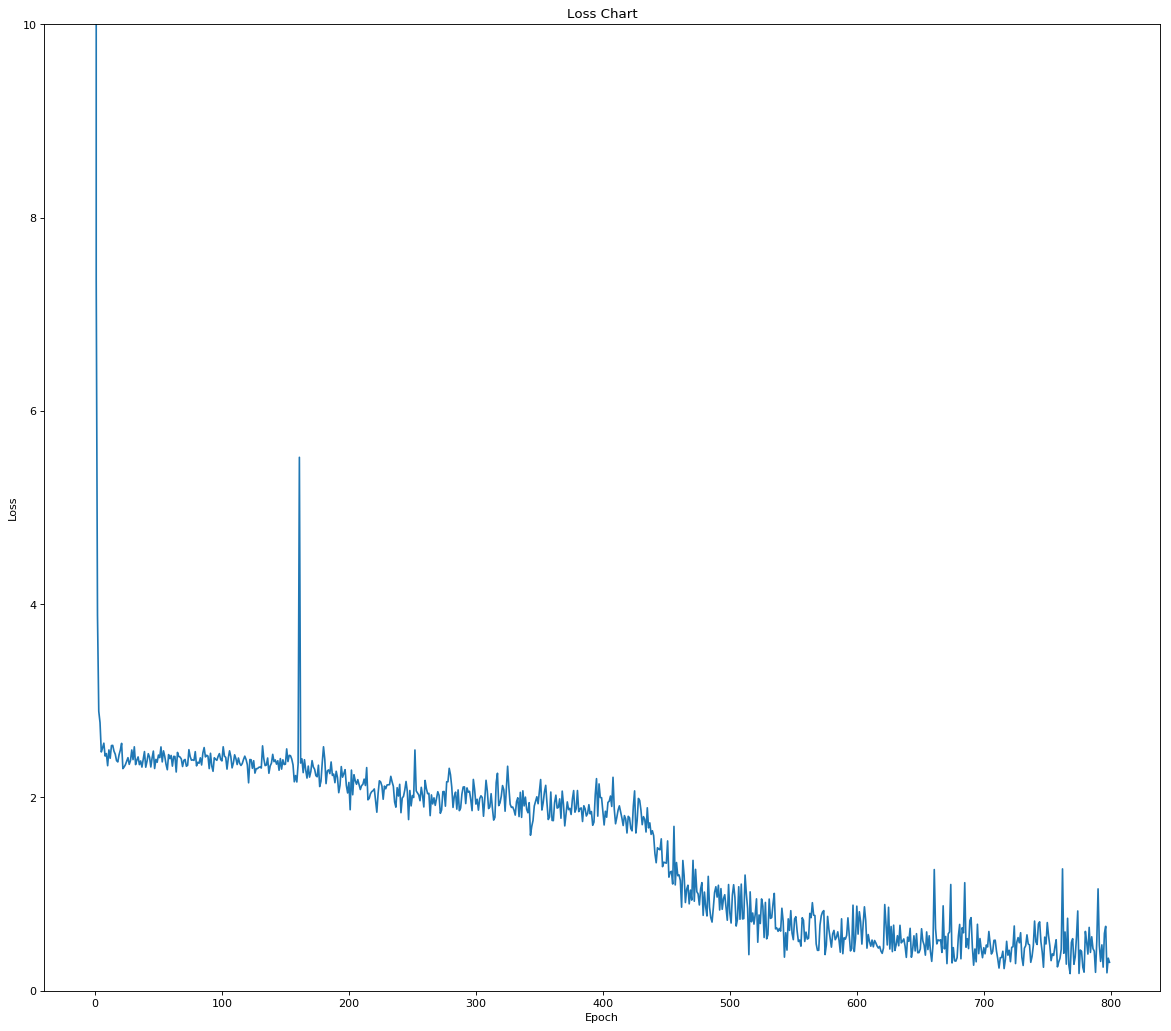

In [34]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.ylim(0,10)
plt.title('Loss Chart')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(plot_data)

In [35]:
outs_ = []
with tf.Session() as sess:    
    saver = tf.train.import_meta_graph('seedlings-model.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("Placeholder:0")
    for i in range(len(test_data)):
        feed ={x: [test_data[i][0]], hold_prob:1}

        op_to_restore = tf.nn.softmax(graph.get_tensor_by_name("add_3:0"))

        aaa = sess.run(op_to_restore, feed).ravel().tolist()
        aaa = aaa.index(max(aaa))
        print(dirs[aaa])
        outs_.append([test_data[i][1], dirs[aaa]])

INFO:tensorflow:Restoring parameters from ./seedlings-model.ckpt
Sugar beet
Loose Silky-bent
Small-flowered Cranesbill
Maize
Charlock
Common wheat
Common Chickweed
Cleavers
Small-flowered Cranesbill
Maize
Cleavers
Common Chickweed
Scentless Mayweed
Small-flowered Cranesbill
Loose Silky-bent
Fat Hen
Common Chickweed
Common Chickweed
Common wheat
Scentless Mayweed
Scentless Mayweed
Scentless Mayweed
Loose Silky-bent
Loose Silky-bent
Small-flowered Cranesbill
Common Chickweed
Charlock
Charlock
Small-flowered Cranesbill
Loose Silky-bent
Cleavers
Small-flowered Cranesbill
Maize
Charlock
Loose Silky-bent
Loose Silky-bent
Charlock
Fat Hen
Sugar beet
Common Chickweed
Fat Hen
Sugar beet
Loose Silky-bent
Fat Hen
Common Chickweed
Shepherds Purse
Common Chickweed
Small-flowered Cranesbill
Loose Silky-bent
Sugar beet
Common Chickweed
Maize
Common Chickweed
Maize
Charlock
Small-flowered Cranesbill
Scentless Mayweed
Fat Hen
Common Chickweed
Sugar beet
Loose Silky-bent
Maize
Common wheat
Loose Silky-b

Small-flowered Cranesbill
Loose Silky-bent
Common Chickweed
Shepherds Purse
Charlock
Sugar beet
Fat Hen
Shepherds Purse
Scentless Mayweed
Small-flowered Cranesbill
Common Chickweed
Loose Silky-bent
Sugar beet
Charlock
Fat Hen
Loose Silky-bent
Common Chickweed
Common Chickweed
Cleavers
Common Chickweed
Fat Hen
Cleavers
Scentless Mayweed
Loose Silky-bent
Shepherds Purse
Common Chickweed
Scentless Mayweed
Common Chickweed
Scentless Mayweed
Loose Silky-bent
Shepherds Purse
Shepherds Purse
Small-flowered Cranesbill
Loose Silky-bent
Shepherds Purse
Sugar beet
Loose Silky-bent
Small-flowered Cranesbill
Loose Silky-bent
Common Chickweed
Sugar beet
Scentless Mayweed
Fat Hen
Maize
Maize
Small-flowered Cranesbill
Loose Silky-bent
Common Chickweed
Black-grass
Maize
Cleavers
Loose Silky-bent
Loose Silky-bent
Fat Hen
Fat Hen
Loose Silky-bent
Scentless Mayweed
Sugar beet
Loose Silky-bent
Small-flowered Cranesbill
Small-flowered Cranesbill
Loose Silky-bent
Common Chickweed
Fat Hen
Sugar beet
Shepherds

## Writing csv submition

In [36]:
import csv
with open('submition.csv', 'w') as csvfile:
    fieldnames = ['file', 'species']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for i in range(len(outs_)):
        writer.writerow({'file': outs_[i][0], 'species':outs_[i][1]})
    print("csv file ready")

csv file ready
